In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Import necessary libraries
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils import class_weight
import seaborn as sns

In [ ]:
# Define paths to the dataset
dataset_dir = "/content/drive/MyDrive/Tea leaf dataset/Tea leaf dataset"

In [ ]:
# Aggressive image data generator for augmentation
datagen = ImageDataGenerator(
    rescale=1.0 / 255.0,          # Normalize pixel values
    rotation_range=60,           # Randomly rotate images
    width_shift_range=0.4,       # Randomly shift images horizontally
    height_shift_range=0.4,      # Randomly shift images vertically
    shear_range=0.4,             # Shear transformation
    zoom_range=0.4,              # Random zoom
    horizontal_flip=True,        # Randomly flip images horizontally
    vertical_flip=True,          # Randomly flip images vertically
    validation_split=0.2         # Reserve 20% of data for validation
)

# Load training and validation datasets
train_generator = datagen.flow_from_directory(
    dataset_dir,
    target_size=(128, 128),      # Resize images to 128x128
    batch_size=32,
    class_mode='categorical',    # Multi-class classification (one-hot encoding)
    subset='training'
)

validation_generator = datagen.flow_from_directory(
    dataset_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',    # Multi-class classification (one-hot encoding)
    subset='validation'
)

Found 3169 images belonging to 4 classes.
Found 791 images belonging to 4 classes.


In [ ]:
# Calculate steps_per_epoch and validation_steps
steps_per_epoch = train_generator.samples // train_generator.batch_size
validation_steps = validation_generator.samples // validation_generator.batch_size

In [ ]:
# Compute class weights to handle dataset imbalance
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)

class_weights_dict = dict(enumerate(class_weights))
print("Class weights:", class_weights_dict)

Class weights: {0: np.float64(0.43626101321585903), 1: np.float64(1.9417892156862746), 2: np.float64(1.7644766146993318), 3: np.float64(1.5972782258064515)}


In [ ]:
# Load the VGG16 model (pre-trained on ImageNet) without the top layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [ ]:
# Freeze the base model layers initially
for layer in base_model.layers:
    layer.trainable = False

In [ ]:
# Build the model
model = Sequential([
    base_model,  # Add the pre-trained VGG16 model
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(4, activation='softmax')  # Output layer for 4 classes
])

In [ ]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
# Print model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 4, 4, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     4,194,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         2,052 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,911,556 (72.14 MB)

 Trainable params: 4,196,868 (16.01 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [ ]:
# Train the model with class weights
history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    validation_data=validation_generator,
    validation_steps=validation_steps,
    epochs=50,
    class_weight=class_weights_dict
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 1028s 10s/step - accuracy: 0.6470 - loss: 1.0278 - val_accuracy: 0.9089 - val_loss: 0.3574
Epoch 2/50
 1/99 ━━━━━━━━━━━━━━━━━━━━ 9s 92ms/step - accuracy: 0.8438 - loss: 0.4389

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


99/99 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - accuracy: 0.8438 - loss: 0.4389 - val_accuracy: 0.9062 - val_loss: 0.3594
Epoch 3/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 83s 812ms/step - accuracy: 0.8591 - loss: 0.4900 - val_accuracy: 0.9062 - val_loss: 0.3197
Epoch 4/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 10s 103ms/step - accuracy: 0.9375 - loss: 0.3702 - val_accuracy: 0.9089 - val_loss: 0.3120
Epoch 5/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 96s 454ms/step - accuracy: 0.8918 - loss: 0.3760 - val_accuracy: 0.9049 - val_loss: 0.3091
Epoch 6/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 10s 100ms/step - accuracy: 0.9688 - loss: 0.3032 - val_accuracy: 0.9206 - val_loss: 0.2965
Epoch 7/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 81s 542ms/step - accuracy: 0.8996 - loss: 0.3838 - val_accuracy: 0.9245 - val_loss: 0.2603
Epoch 8/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 10s 96ms/step - accuracy: 0.9375 - loss: 0.2240 - val_accuracy: 0.9284 - val_loss: 0.2466
Epoch 9/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 46s 468ms/step - accuracy: 0.9110 - loss: 0.3240 - val_accuracy: 0.9245

Initial Training Results:


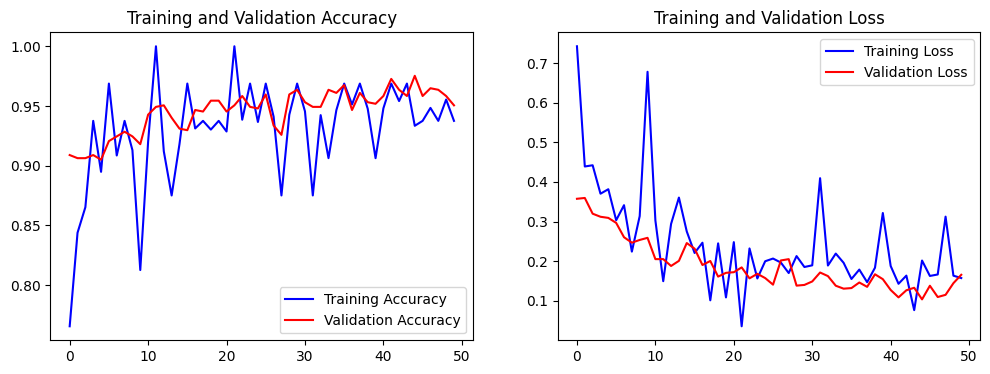

Fine-Tuning Results:


AttributeError: module 'matplotlib.pyplot' has no attribute 'plot_training_history'

In [ ]:
# Plot training and validation accuracy/loss
def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.figure(figsize=(12, 4))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b', label='Training Loss')
    plt.plot(epochs, val_loss, 'r', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    plt.show()

# Plot the results
print("Initial Training Results:")
plot_training_history(history)
print("Fine-Tuning Results:")
plot_training_history(history_finetune)

In [ ]:
# Evaluate the model on the validation set
test_loss, test_accuracy = model.evaluate(validation_generator, steps=validation_steps)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")

24/24 ━━━━━━━━━━━━━━━━━━━━ 10s 404ms/step - accuracy: 0.9475 - loss: 0.1591
Test Accuracy: 95.83%
Test Loss: 0.1487


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


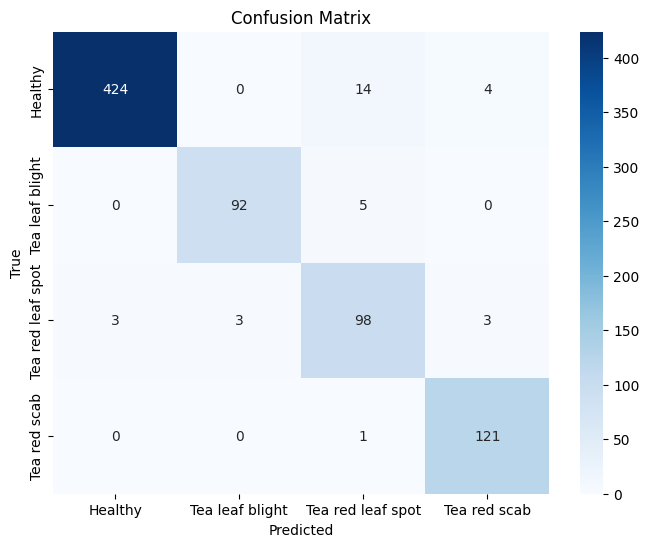

                   precision    recall  f1-score   support

          Healthy       0.99      0.96      0.98       442
  Tea leaf blight       0.97      0.95      0.96        97
Tea red leaf spot       0.83      0.92      0.87       107
     Tea red scab       0.95      0.99      0.97       122

         accuracy                           0.96       768
        macro avg       0.93      0.95      0.94       768
     weighted avg       0.96      0.96      0.96       768

Model saved successfully!


In [ ]:

# Generate confusion matrix and classification report
def evaluate_model(model, validation_generator, validation_steps):
    # Get true labels and predictions
    y_true = []
    y_pred = []
    for i in range(validation_steps):
        images, labels = next(validation_generator)
        y_true.extend(np.argmax(labels, axis=1))
        y_pred.extend(np.argmax(model.predict(images), axis=1))

    class_labels = list(validation_generator.class_indices.keys())

    # Generate confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    # Print classification report
    print(classification_report(y_true, y_pred, target_names=class_labels))

# Evaluate the model
evaluate_model(model, validation_generator, validation_steps)

# Save the model in the new .keras format
model.save("tea_leaf_disease_model.keras")
print("Model saved successfully!")